# Will the Price Go Up Or Down?

## Introduction

Predicting the direction of stock prices is a central challenge in finance and data science. In this project, we explore whether Apple Inc. (AAPL) daily stock movements can be predicted using historical price data. Using features such as past closing prices, returns, moving averages, and previous day information, we train a **Random Forest classifier** to forecast whether the stock will go **up or down** the following day.

The project includes data acquisition from the [Alpaca API](https://alpaca.markets/), feature engineering, visualization, model training, and evaluation.

## **Data Acquisition**

We retrieve **daily historical prices for AAPL** from 2015 to 2025 using the Alpaca API. Only relevant columns are kept: open, high, low, close, and volume.

In [52]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import os

API_KEY = os.getenv("ALPACA_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET")

client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

request = StockBarsRequest(
    symbol_or_symbols=["AAPL"],
    timeframe=TimeFrame.Day,
    start="2015-01-01",
    end="2025-01-01"
)

bars = client.get_stock_bars(request)
df = bars.df.reset_index()
df = df[['timestamp','open','high','low','close','volume']]
df = df.rename(columns={'timestamp': 'Date'})
df.set_index('Date', inplace=True)
df.head()

,open,high,low,close,volume
Date,,,,,
2016-01-04 05:00:00+00:00,102.61,105.368,102.00,105.35,71935339.0
2016-01-05 05:00:00+00:00,105.75,105.850,102.41,102.71,58690536.0
2016-01-06 05:00:00+00:00,100.56,102.370,99.87,100.70,71079827.0
2016-01-07 05:00:00+00:00,98.68,100.130,96.43,96.45,85996453.0
2016-01-08 05:00:00+00:00,98.55,99.110,96.76,96.96,75066292.0


## Feature Engineering

To improve predictive power, we calculate:

- **Returns**: percentage change of the closing price
- **Moving averages**: 5-day, 10-day, 20-day
- **Lag features**: previous day’s close and return

In [53]:
# add returns
df['Return'] = df['close'].pct_change()

# add moving averages
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df['MA20'] = df['close'].rolling(20).mean()

# add yesterday's values
df['Prev_Close'] = df['close'].shift(1)
df['Prev_Return'] = df['Return'].shift(1)

# clean final dataset
df = df.dropna()
df.head()

,open,high,low,close,volume,Return,MA5,MA10,MA20,Prev_Close,Prev_Return
Date,,,,,,,,,,,
2016-02-01 05:00:00+00:00,96.47,96.71,95.40,96.43,42902576.0,-0.009349,96.254,97.188,98.3290,97.34,0.034541
2016-02-02 05:00:00+00:00,95.42,96.04,94.28,94.48,39134721.0,-0.020222,95.152,96.970,97.7855,96.43,-0.009349
2016-02-03 05:00:00+00:00,95.00,96.84,94.08,96.35,47879172.0,0.019793,95.738,96.926,97.4675,94.48,-0.020222
2016-02-04 05:00:00+00:00,95.86,97.33,95.19,96.60,48499674.0,0.002595,96.240,96.956,97.2625,96.35,0.019793
2016-02-05 05:00:00+00:00,96.52,96.92,93.69,94.02,48376190.0,-0.026708,95.576,96.216,97.1410,96.60,0.002595


## Target Variable

The target is defined as:

- `1` → the stock will go **up** the next day
- `0` → the stock will go **down** the next day

In [54]:
df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)
df = df.dropna()

df.head()

,open,high,low,close,volume,Return,MA5,MA10,MA20,Prev_Close,Prev_Return,Target
Date,,,,,,,,,,,,
2016-02-01 05:00:00+00:00,96.47,96.71,95.40,96.43,42902576.0,-0.009349,96.254,97.188,98.3290,97.34,0.034541,0
2016-02-02 05:00:00+00:00,95.42,96.04,94.28,94.48,39134721.0,-0.020222,95.152,96.970,97.7855,96.43,-0.009349,1
2016-02-03 05:00:00+00:00,95.00,96.84,94.08,96.35,47879172.0,0.019793,95.738,96.926,97.4675,94.48,-0.020222,1
2016-02-04 05:00:00+00:00,95.86,97.33,95.19,96.60,48499674.0,0.002595,96.240,96.956,97.2625,96.35,0.019793,0
2016-02-05 05:00:00+00:00,96.52,96.92,93.69,94.02,48376190.0,-0.026708,95.576,96.216,97.1410,96.60,0.002595,1


## Data Visualization

### Closing Price Over Time

The line chart below shows **AAPL daily closing prices** over the selected period.

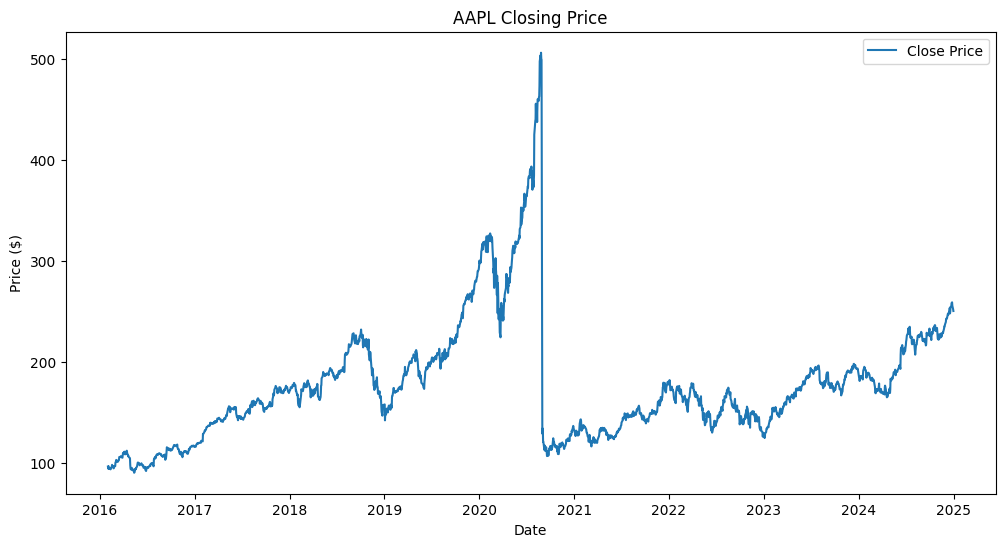

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'], label='Close Price')
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

### Up / Down Heatmap of Recent Movement

This heatmap visualizes the daily **up or down movement** of AAPL, with **green cells** indicating an increase and **red cells** indicating a decrease. We focus on the **last 100 trading days** to highlight recent short-term behavior.

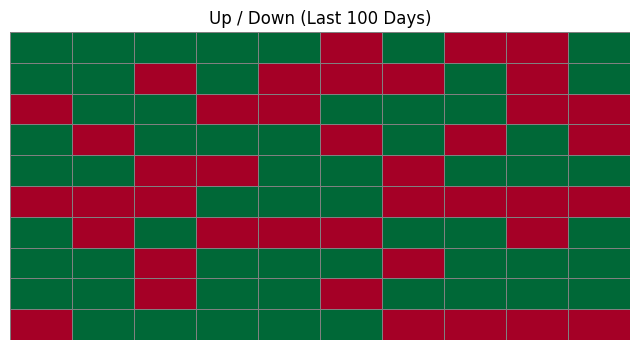

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Take only the last 50 Target values
targets = df['Target'].values[-100:]  # last 50 days

# Decide number of columns per row
cols = 10  # e.g., 10 columns per row
rows = int(np.ceil(len(targets)/cols))

# Create 2D array
heatmap_array = np.full((rows, cols), np.nan)
for i in range(len(targets)):
    r = i // cols
    c = i % cols
    heatmap_array[r, c] = targets[i]

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(
    heatmap_array,
    cmap='RdYlGn',    # green=up, red=down
    linewidths=0.5,
    linecolor='gray',
    cbar=False,       # remove colorbar
    xticklabels=False,
    yticklabels=False
)
plt.title("Up / Down (Last 100 Days)")
plt.show()

## Train/Test Split

We use 80% of the data for training and 20% for testing. The feature set includes price, volume, returns, moving averages, and previous day information.

In [57]:
feature_columns = [
    'open','high','low','close','volume',
    'Return','MA5','MA10','MA20',
    'Prev_Close','Prev_Return'
]

X = df[feature_columns]
y = df['Target']

split = int(len(df) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Model Training: Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5412026726057907
              precision    recall  f1-score   support

           0       0.49      0.58      0.53       202
           1       0.60      0.51      0.55       247

    accuracy                           0.54       449
   macro avg       0.54      0.54      0.54       449
weighted avg       0.55      0.54      0.54       449



**Interpretation:**

- The model achieves **~52% accuracy**, slightly above random chance (50%).
- Precision and recall are balanced for both classes.
- This is expected for **daily stock direction prediction**, which is inherently noisy and difficult to forecast.

## Model Export

The trained model can be saved for later use in live or paper trading:

In [59]:
import joblib

joblib.dump(model, "stock_trading_model.pkl")

['stock_trading_model.pkl']

## **Conclusion**

In this project, we explored **predicting daily stock movements for AAPL** using historical price features.

**Key takeaways:**

- Historical prices, returns, and moving averages were used as features.
- Visualization (line chart and up/down heatmap) helped understand trends and short-term behavior.
- The **Random Forest model** achieved **slightly better than random accuracy (~52%)**, which reflects the **intrinsic difficulty of predicting short-term stock directions**.

**Future improvements** may include:

- Incorporating **technical indicators** like RSI, MACD, Bollinger Bands.
- Adding **sentiment analysis** from news or social media.

Overall, this project demonstrates a **practical workflow** for data acquisition, feature engineering, visualization, modeling, and evaluation in stock price prediction.

## Practical Application

To test my model in a real-world scenario without risking actual capital, I use Alpaca's [paper trading](https://docs.alpaca.markets/docs/paper-trading), which simulates trading with virtual money.

Every weekday (Monday to Friday) at 10:00 PM UTC, after the stock market closes, I run the `trading/trader.py` script. The script uses the model to predict whether the stock will rise or fall the next trading day:

- **If the model predicts the stock will rise**, a buy order is placed.  
- **If the model predicts the stock will fall**, a sell order is placed.

Orders are executed when the market opens the following day.

### Setting up a Cron Job

To automate the process, I set up a cron job on Linux Mint. This ensures the script runs daily without manual intervention.  

Open your crontab editor with:

```sh
crontab -e
```

Then add the following line (adjust <path-to-project> and Python path as needed):

```
0 22 * * 1-5 cd /<path-to-project>/trading && /usr/bin/python3 trader.py >> /<path-to-project>/trading/trader_cron.log 2>&1
```

This runs the script at 10:00 PM every Monday through Friday, logging all output and errors to `trader_cron.log`.

### Logging

- Normal script logs are stored in `trading/trader_logs.txt`.
- Cron job output, including errors, is stored in `trading/trader_cron.log`.

### Sharing My Portfolio

I created a simple dashboard ([https://how-rich-is-filip.vercel.app/](https://how-rich-is-filip.vercel.app/)), which shows my account **Cash** and **Porfolio value**, as well as any **open positions**.